# Data processing

# Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from constants import NUM_SELECTED

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer


# Data Loading

In [3]:
X_list = []
y_list = []

X_train = pd.read_parquet("../../../../../data/interim/copper/X_train.parquet")
y_train = pd.read_parquet("../../../../../data/interim/copper/y_train_cat.parquet")
X_test = pd.read_parquet("../../../../../data/interim/copper/X_test_rf.parquet")

# Principal Component Analysis

In [4]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5)),
    ( 'pca', PCA(n_components=len(NUM_SELECTED)))
])

numeric_transformer.fit(X_train[NUM_SELECTED])

pca = numeric_transformer.named_steps['pca']

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_.reshape(-1, 1)

weights = pd.DataFrame(explained_variance_ratio*100, columns=["Variância (%)"])
weights["Componente"] = range(1, len(NUM_SELECTED)+1)
weights["Variância Acumulada (%)"] = weights["Variância (%)"].cumsum()

In [5]:
weights

,Variância (%),Componente,Variância Acumulada (%)
0,32.754695,1,32.754695
1,19.141105,2,51.895800
2,15.915746,3,67.811546
3,9.970494,4,77.782040
4,6.847830,5,84.629870
5,5.153773,6,89.783642
6,3.595216,7,93.378858
7,3.009016,8,96.387875
8,2.116550,9,98.504425
9,1.489901,10,99.994325


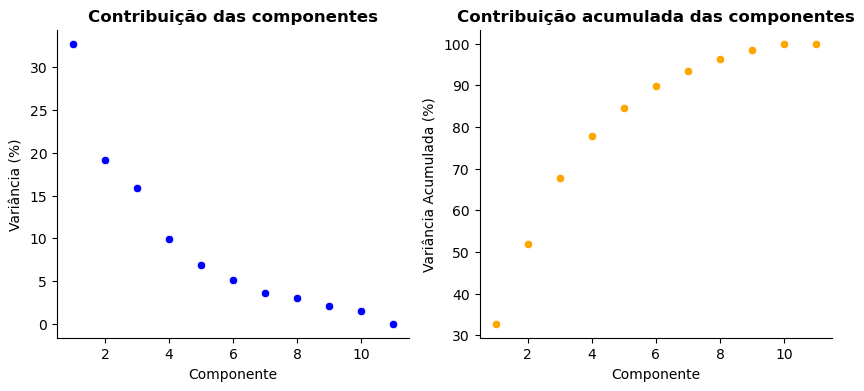

In [6]:
# Plot the explained variance ratio
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(weights, x="Componente", y="Variância (%)", ax=ax[0], color = 'blue')
ax[0].set_title('Contribuição das componentes', weight='bold')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

sns.scatterplot(weights, x="Componente", y="Variância Acumulada (%)", ax=ax[1], color = "orange")
ax[1].set_title('Contribuição acumulada das componentes', weight='bold')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.show()